In [2]:
from glob import glob
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import tensorflow as tf
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from tqdm import tqdm

In [3]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [4]:
SAMPLE_FILE = "/app/_data/competition_data/train_short_audio/acafly/XC11209.ogg"
TARGET_LEN_S = 5

In [5]:
ipd.Audio(SAMPLE_FILE)

In [6]:
x, sr = librosa.load(SAMPLE_FILE, sr=32000)
x = x[:TARGET_LEN_S*sr]
x.shape, sr, x.shape[0] / sr

((160000,), 32000, 5.0)

In [7]:
x -= np.mean(x)
x /= np.std(x)

In [8]:
ipd.Audio(data=x.astype(np.float16), rate=32000)

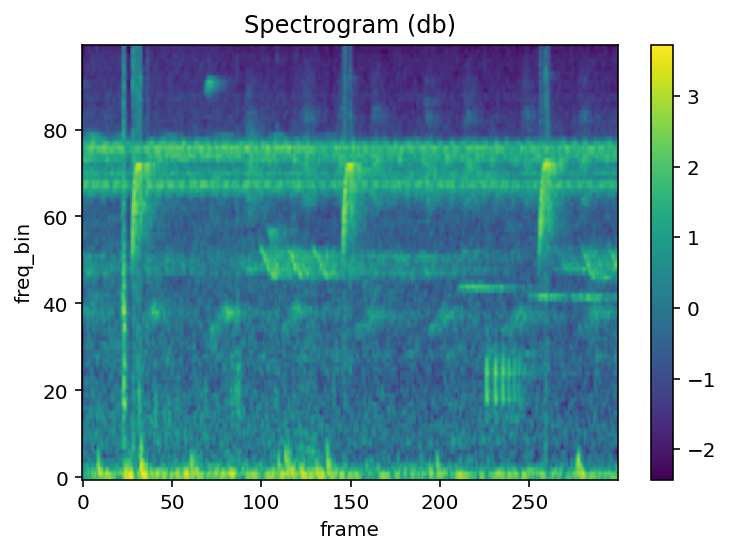

(100, 300)


In [9]:
msg_w = 300
msg_h = 100

n_fft = 2048
hop_length = x.shape[0] // msg_w
n_mels = msg_h


hop_length = x.shape[0] // (msg_w - 1)


_melspec = None


def msg_t(
    x,
    sr=32000,
    n_fft=2048,
    hop_length=None,
    n_mels=224,
    device="cpu",
    recreate_melspec=False,
):

    global _melspec

    x = torch.tensor(x.reshape([1, -1])).to(device)

    if recreate_melspec or _melspec is None:

        _melspec = T.MelSpectrogram(
            sample_rate=sr,
            n_fft=n_fft,
            win_length=None,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
        ).to(device)

    return _melspec(x)[0].cpu()


msg = msg_t(
    x,
    sr=32000,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    device="cpu",
)

msg = librosa.power_to_db(msg)

msg -= np.mean(msg)
msg /= np.std(msg)

plot_spectrogram(msg)
print(msg.shape)

In [10]:
_melspec = None
for i in tqdm(range(1_000_000)):
    msg = msg = msg_t(x, sr, device='cpu', recreate_melspec=False)

  6%|▌         | 56460/1000000 [00:50<13:58, 1125.61it/s]


KeyboardInterrupt: 

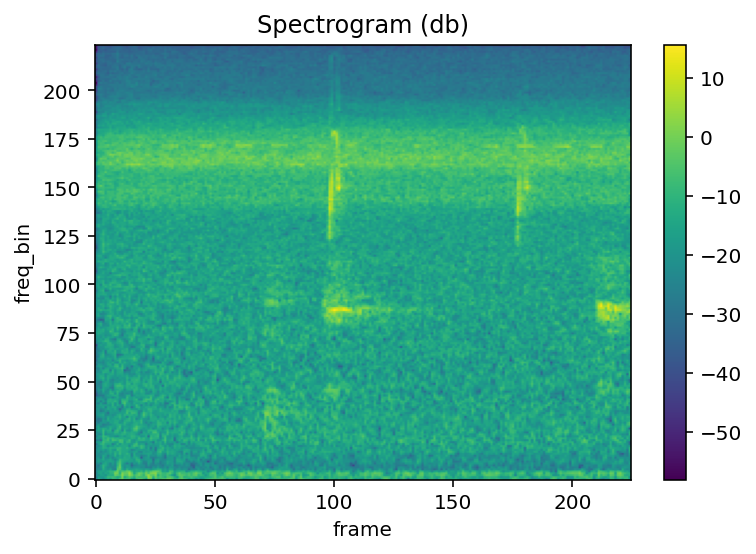

In [92]:
def msg_lr(x, sr=32000, n_fft=2048, hop_length=None, n_mels=224):

    if hop_length is None:
        hop_length = x.shape[0] // 224

    msg = librosa.feature.melspectrogram(
        x,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )

    return msg


msg = msg_lr(x, sr)
plot_spectrogram(msg)

In [93]:
for i in tqdm(range(100)):
    msg = msg = msg_lr(x, sr)

100%|██████████| 100/100 [00:01<00:00, 64.63it/s]


In [138]:
# benchmark T msg

_melspec = None
msg = msg_t(x, sr, device="cpu")


def _map(_):
    msg_t(x, sr, device="cpu")


def _map2(_):

    hop_length = x.shape[0] // 224
    x_t = torch.tensor(x.reshape([1, -1]))

    melspec = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        win_length=None,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
    )

    _ = melspec(x_t).cpu()


with Pool(cpu_count()) as pool:
    _ = list(
        tqdm(
            pool.imap(
                _map2,
                range(1000),
            ),
            total=1000,
            smoothing=0,
        )
    )

  0%|          | 0/1000 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [132]:
# benchmark LR msg

def _map(_):
    msg_lr(x, sr)


with Pool(1) as pool:
    _ = list(
        tqdm(
            pool.imap(
                _map,
                range(1000),
            ),
            total=1000,
            smoothing=0,
        )
    )

100%|██████████| 1000/1000 [00:13<00:00, 74.64it/s]
